# E1: 2D snapshot validation (guided SDE vs. explicit $p_t^{(*)}$)

This notebook implements the **E1** validation described in Appendix B.2:
- Simulate the guided SDE with **$X(0)=0$** under a generic PWC protocol $\Gamma_t=(\beta_t,\nu_t)$.
- At selected times, overlay (i) simulated particles, (ii) samples from the target Gaussian mixture, and (iii) **contours of the analytic log-density** $\log p_t^{(*)}(x)$.

All analytic quantities are evaluated using the continuous formulas implemented in `guided_continuous`.

In [1]:
# -----------------------------------------------------------------------------
# Imports and module wiring (hardwired root)
# -----------------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import torch

ROOT = Path(r"/Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks")


if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

device = torch.device("cpu")
dtype  = torch.float64

print("Repo ROOT:", ROOT)
print("device:", device, "dtype:", dtype)

from guided_continuous import PWCProtocol, ContinuousCoeffs, GaussianMixture

Repo ROOT: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks
device: cpu dtype: torch.float64


## Additional imports and plotting configuration
The first cell wires `ROOT` into `sys.path` exactly as in `test_continuous.ipynb`.
Here we import the remaining objects needed for E1 and set some convenience defaults.

In [2]:
import math
import matplotlib.pyplot as plt

from guided_continuous import GuidedField, euler_maruyama_guided, heun_guided, TimeDomain

# Matplotlib defaults (feel free to adjust)
plt.rcParams["figure.dpi"] = 130


## Define a generic 2D test problem
We construct:
1. A **non-degenerate PWC protocol** with a few breakpoints.
2. A **2D Gaussian mixture** in generic position.
3. The continuous coefficients and the guided field.

The goal is to keep this example simple but non-trivial (no symmetry, non-diagonal covariances).

In [3]:
# -----------------------------------------------------------------------------
# Safe SPD constructors for 2x2 covariances + a "general position" 2D GM example
# -----------------------------------------------------------------------------
import torch

def make_spd_2x2(A, jitter=0.20, *, dtype=torch.float64, device="cpu"):
    """Guaranteed SPD: Sigma = A A^T + jitter * I, with symmetry enforced."""
    A = torch.as_tensor(A, dtype=dtype, device=device)
    S = A @ A.T
    S = 0.5 * (S + S.T)
    S = S + jitter * torch.eye(2, dtype=dtype, device=device)
    return S

def rot(theta, *, dtype=torch.float64, device="cpu"):
    """2D rotation matrix."""
    th = torch.as_tensor(theta, dtype=dtype, device=device)
    c, s = torch.cos(th), torch.sin(th)
    return torch.stack([torch.stack([c, -s]),
                        torch.stack([s,  c])], dim=0)

def spd_from_axes(theta, lam1=0.15, lam2=0.60, *, dtype=torch.float64, device="cpu", jitter=1e-6):
    """SPD ellipse covariance via rotated principal axes."""
    R = rot(theta, dtype=dtype, device=device)
    D = torch.diag(torch.as_tensor([lam1, lam2], dtype=dtype, device=device))
    S = R @ D @ R.T
    S = 0.5 * (S + S.T) + jitter * torch.eye(2, dtype=dtype, device=device)
    return S


def make_example(*, B: int = 6000, n_steps: int = 2500, seed: int = 1, device=None, dtype=None, eps: float = 1e-4):
    """Construct a generic 2D test instance (protocol + target GM + field).

    Notes:
      * We enforce an interior time policy t in [eps, 1-eps] globally (TimeDomain).
      * Covariances are SPD by construction to avoid numerical Cholesky failures.
    """
    if dtype is None:
        dtype = torch.float64
    if device is None:
        device = torch.device("cpu")  # switch to torch.device("cuda") for GPU

    time_domain = TimeDomain(eps=eps)

    # --- PWC protocol (simple but non-degenerate) ---
    """
    breaks = torch.tensor([0.0, 0.35, 0.70, 1.0], dtype=dtype, device=device)
    beta_vals = torch.tensor([1.0, 0.8, 1.2], dtype=dtype, device=device)  # (M,)
    nu_vals = torch.tensor([[0.1, 0.08],
                            [0.6, 0.05],
                            [1., 0.10]], dtype=dtype, device=device)      # (M,d)
                            """

    breaks = torch.tensor([0.0, 0.25, 0.50, 0.75, 1.0], dtype=dtype, device=device)
    beta_vals = torch.tensor([5.0, 4.0, 3.0, 1.0], dtype=dtype, device=device)  # (M,)
    nu_vals = torch.tensor([[0.0, 0.0],
                            [0.4, 0.06],
                            [0.8, 0.12], 
                            [1.2, 0.18]], dtype=dtype, device=device)      # (M,d)

    beta = PWCProtocol(breaks, beta_vals, time_domain=time_domain)
    nu   = PWCProtocol(breaks, nu_vals,  time_domain=time_domain)

    # --- Target Gaussian mixture (2D, general position; SPD covariances) ---
    weights = torch.tensor([0.45, 0.35, 0.20], dtype=dtype, device=device)
    means   = torch.tensor([[ 2.30,  0.20],
                            [0.3,  0.80],
                            [0.4, -0.90]], dtype=dtype, device=device)

    covs = torch.stack([
        spd_from_axes(theta=0.35,  lam1=0.10, lam2=0.55, dtype=dtype, device=device),
        spd_from_axes(theta=-0.70, lam1=0.14, lam2=0.70, dtype=dtype, device=device),
        spd_from_axes(theta=1.10,  lam1=0.08, lam2=0.45, dtype=dtype, device=device),
    ], dim=0)

    # Sanity: SPD eigenvalues
    evals = torch.linalg.eigvalsh(covs)
    print("Sigma eigenvalues (min per component):", evals.min(dim=1).values.detach().cpu().numpy())

    gm = GaussianMixture(weights=weights, means=means, covs=covs)

    # --- Continuous coefficients and guided field ---
    coeffs = ContinuousCoeffs(beta=beta, nu=nu, time_domain=time_domain)
    field  = GuidedField(coeffs=coeffs, target=gm, time_domain=time_domain)

    return beta, nu, gm, field, time_domain, device, dtype


## Simulate the guided SDE with $X(0)=0$
We integrate
$$
\mathrm{d}X_t = u_t^{(*)}(X_t)\,\mathrm{d}t + \mathrm{d}W_t,
\qquad X_0=0,
$$
using Euler–Maruyama on a uniform grid. The drift is provided by `field.u_star(t, x)`.

We keep the simulator Torch-native so it runs on CPU or GPU.

In [4]:
# Build the example objects
beta, nu, gm, field, time_domain, device, dtype = make_example(
    B=6000, n_steps=2500, seed=1, device=device, dtype=dtype, eps=1e-6
)

# Simulator expects: u_star(t,x) and nu_of_t(t) returning a scalar diffusion value
def u_star(t, x):
    return field.u_star(t, x)


# Run the simulation (X0=0) on the interior time grid [eps, 1-eps]

breaks = torch.tensor([0.0, 0.25, 0.50, 0.75, 1.0], dtype=dtype, device=device)


res = euler_maruyama_guided(
    field.u_star,
    B=6000,
    d=2,
    n_steps=2500,
    dtype=dtype,
    device=device,
    seed=0,
    x0_zero=True,
    time_domain=time_domain,
    breaks=breaks,
    post_jump_eps=1e-12,
)
"""
res = heun_guided(
    field.u_star,
    B=6000,
    d=2,
    n_steps=2500,
    dtype=dtype,
    device=device,
    seed=0,
    x0_zero=True,
    time_domain=time_domain,
    breaks=breaks,
    post_jump_eps=1e-12,
)
"""


print("traj:", tuple(res.traj.shape), "times:", tuple(res.times.shape),
      "device:", res.traj.device, "dtype:", res.traj.dtype,
      "t-range:", float(res.times[0]), "to", float(res.times[-1]))


Sigma eigenvalues (min per component): [0.100001 0.140001 0.080001]
traj: (2501, 6000, 2) times: (2501,) device: cpu dtype: torch.float64 t-range: 1e-06 to 0.999999


## Plot E1 snapshots with samples from $p_t^{(*)}$

For each selected interior time $t$, we overlay three ensembles of points, all
with the same cardinality:

- **Target samples** drawn from the terminal Gaussian mixture
  $\mathrm{GM}=\{\pi_k,m_k,\Sigma_k\}$ (gray), serving as a visual reference.
- **Guided particles** (yellow) obtained by simulating the controlled SDE
  with optimal drift $u_t^{(*)}$ using the Euler–Maruyama scheme, starting from
  $X(0)=0$.
- **Analytic samples** (green) drawn directly from the explicit marginal density
  $p_t^{(*)}(x)$, evaluated via its closed-form Gaussian-mixture representation
  derived from Eq. (B.12).

This side-by-side comparison provides a direct empirical–analytic validation of
the implementation: agreement between the green and yellow clouds indicates
consistency between the explicit formulas and the stochastic simulation, while
agreement with the gray target at $t=1$ confirms convergence to the desired
terminal distribution.

The resulting figure is displayed inline and also saved as a PNG file in
`guided_continuous/test/figs/`.

Saved: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e1_snapshots_2d.png


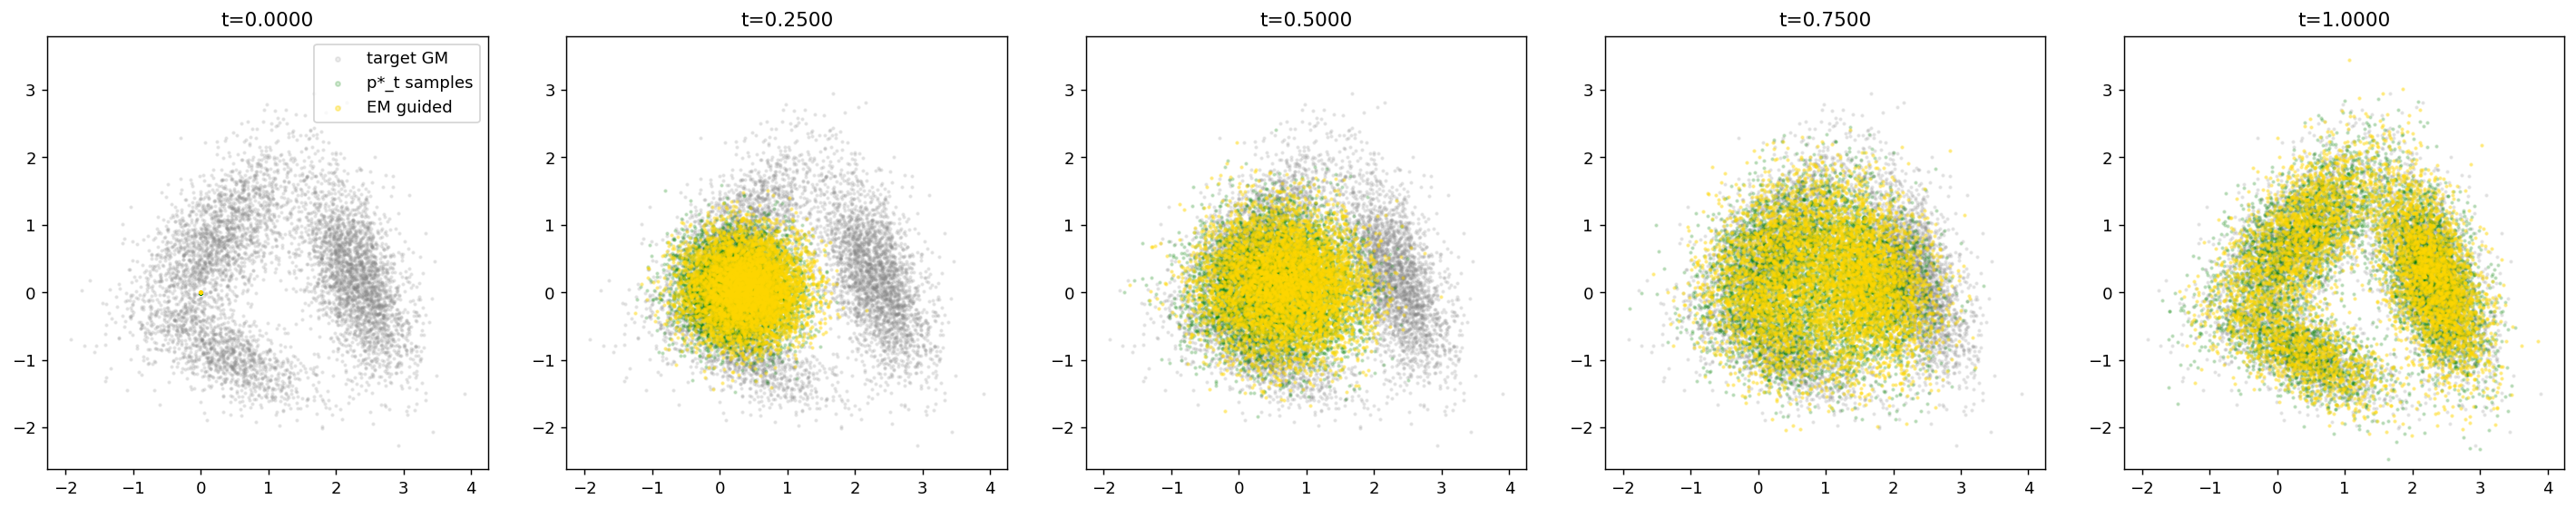

In [5]:
# -----------------------------------------------------------------------------
# Plotting helpers: GM sampling (gray), EM particles (yellow), p*_t sampling (green)
# plus optional log p*_t contours (can be turned off)
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

def sample_from_gm(gm, n, dtype, device, seed=0):
    """
    Sample n points from a 2D Gaussian mixture gm = {weights, means, covs}
    in a Torch-version compatible way (no generator kwarg on distributions).
    """
    g = torch.Generator(device=device)
    g.manual_seed(int(seed))

    # Component indices via multinomial (supports generator kwarg reliably)
    probs = gm.weights.to(dtype=dtype, device=device)
    probs = probs / probs.sum()  # safety
    k = torch.multinomial(probs, num_samples=int(n), replacement=True, generator=g)  # (n,)

    # Sample each point from its component: x = m_k + L_k eps
    means = gm.means.to(dtype=dtype, device=device)      # (K,2)
    covs  = gm.covs.to(dtype=dtype, device=device)       # (K,2,2)

    eps = torch.randn((int(n), 2), dtype=dtype, device=device, generator=g)  # (n,2)
    y = torch.empty((int(n), 2), dtype=dtype, device=device)

    # Cholesky per component (K is small; loop is fine)
    for kk in range(means.shape[0]):
        mask = (k == kk)
        if mask.any():
            L = torch.linalg.cholesky(covs[kk])
            y[mask] = means[kk] + eps[mask] @ L.T

    return y


def _p_star_mixture_params_2d(field, t):
    """
    Construct the (time-dependent) Gaussian mixture representation of p*_t(x)
    implied by Eq. (p*). Returns:
      w  : (K,) mixture weights (normalized)
      mu : (K,2) component means
      C  : (K,2,2) component covariances (C_k = M_k(t)^{-1})
    """
    # Use dtype/device from coeffs (GuidedField does not export .dtype/.device)
    dtype  = field.coeffs.dtype
    device = field.coeffs.device

    # time handling (scalar -> (1,) tensor), then clamp via TimeDomain
    t = torch.as_tensor(t, dtype=dtype, device=device).reshape(1)
    t = field.time_domain.clamp(t)

    gm = field.target
    K = int(gm.weights.shape[0])
    d = int(gm.means.shape[1])
    assert d == 2, "This helper is specialized for d=2 snapshots."

    I = torch.eye(d, dtype=dtype, device=device)

    # continuous coefficients at time t
    a_p   = field.coeffs.a_plus(t)[0]
    a_m   = field.coeffs.a_minus(t)[0]
    b_m   = field.coeffs.b_minus(t)[0]
    c_m   = field.coeffs.c_minus(t)[0]
    th_p  = field.coeffs.theta_plus(t)[0]
    th_xm = field.coeffs.theta_x_minus(t)[0]
    th_ym = field.coeffs.theta_y_minus(t)[0]

    # endpoint constants are cached in coeffs (no call at t=1!)
    a1p  = field.coeffs.a_plus_1
    th1p = field.coeffs.theta_plus_1

    # derived continuous scalars/vectors
    Kt = c_m - a1p
    Kt = torch.clamp(Kt, min=torch.as_tensor(1e-12, dtype=dtype, device=device))

    alpha = b_m / Kt
    dbar  = (th_ym - th1p) / Kt

    logw_list = []
    mu_list = []
    C_list  = []

    for k in range(K):
        Sig = gm.covs[k].to(dtype=dtype, device=device)
        mk  = gm.means[k].to(dtype=dtype, device=device)

        # S_k(t) = Sigma_k + I/Kt
        S = Sig + (1.0 / Kt) * I
        S = 0.5 * (S + S.T)

        Sinv = torch.linalg.inv(S)

        # M_k(t) = (a+ + a- - b^2/Kt) I + alpha^2 S^{-1}
        M = (a_p + a_m - (b_m*b_m)/Kt) * I + (alpha*alpha) * Sinv
        M = 0.5 * (M + M.T)

        # h_k(t) = theta+ + theta_x^- + b dbar + alpha S^{-1} (m_k - dbar)
        h = th_p + th_xm + b_m * dbar + alpha * (Sinv @ (mk - dbar))

        # Gaussian params: C_k = M^{-1}, mu_k = M^{-1} h
        Ck = torch.linalg.inv(M)
        muk = Ck @ h

        # log weight proportional to:
        #  pi_k |S|^{-1/2} |M|^{-1/2} exp( 0.5 h^T M^{-1} h - 0.5 (m-dbar)^T S^{-1} (m-dbar) )
        signS, logdetS = torch.linalg.slogdet(S)
        signM, logdetM = torch.linalg.slogdet(M)
        if (signS <= 0) or (signM <= 0):
            raise RuntimeError("Non-PD S_k or M_k encountered while building p*_t mixture.")

        quad_h = 0.5 * (h @ (Ck @ h))
        quad_m = 0.5 * ((mk - dbar) @ (Sinv @ (mk - dbar)))

        logwk = torch.log(gm.weights[k].to(dtype=dtype, device=device)) - 0.5*logdetS - 0.5*logdetM + quad_h - quad_m

        logw_list.append(logwk)
        mu_list.append(muk)
        C_list.append(Ck)

    logw = torch.stack(logw_list, dim=0)  # (K,)
    w = torch.softmax(logw, dim=0)        # normalized weights
    mu = torch.stack(mu_list, dim=0)      # (K,2)
    C  = torch.stack(C_list,  dim=0)      # (K,2,2)
    return w, mu, C


def sample_from_p_star_2d(field, t, n, seed=0):
    """
    Sample n points from p*_t(x) in 2D using the implied GM representation.
    Torch-version compatible; uses multinomial + randn with generator.
    """
    dtype  = field.coeffs.dtype
    device = field.coeffs.device

    w, mu, C = _p_star_mixture_params_2d(field, t)  # (K,), (K,2), (K,2,2)
    K = int(w.shape[0])

    g = torch.Generator(device=device)
    g.manual_seed(int(seed))

    k = torch.multinomial(w, num_samples=int(n), replacement=True, generator=g)  # (n,)
    eps = torch.randn((int(n), 2), dtype=dtype, device=device, generator=g)
    out = torch.empty((int(n), 2), dtype=dtype, device=device)

    for kk in range(K):
        mask = (k == kk)
        if mask.any():
            L = torch.linalg.cholesky(C[kk])
            out[mask] = mu[kk] + eps[mask] @ L.T

    return out


def plot_snapshots(field, gm, res, *,
                   times=None,
                   grid_n: int = 140,
                   target_seed: int = 123,
                   pstar_seed: int = 777,
                   show_contours: bool = False):
    traj = res.traj  # (T,B,2)
    tgrid = res.times
    B = traj.shape[1]

    if times is None:
        # Use 5 evenly-spaced interior times, consistent with TimeDomain policy
        times = torch.linspace(float(tgrid[0]), float(tgrid[-1]), 5).tolist()

    # target samples (same B as particles for visual balance)
    with torch.no_grad():
        y = sample_from_gm(gm, B, dtype=traj.dtype, device=traj.device, seed=target_seed)

    # plotting bounds from combined terminal clouds (EM vs target)
    all_xy = torch.cat([traj[-1], y], dim=0).cpu()
    xmin, ymin = all_xy.min(dim=0).values.tolist()
    xmax, ymax = all_xy.max(dim=0).values.tolist()
    pad = 0.35
    xmin -= pad; ymin -= pad; xmax += pad; ymax += pad

    # optional grid for contours of log p*_t
    if show_contours:
        xs = torch.linspace(xmin, xmax, grid_n, dtype=traj.dtype, device=traj.device)
        ys = torch.linspace(ymin, ymax, grid_n, dtype=traj.dtype, device=traj.device)
        X, Y = torch.meshgrid(xs, ys, indexing="xy")
        grid = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)  # (G,2)

    fig, axes = plt.subplots(1, len(times), figsize=(4.4 * len(times), 4.2), constrained_layout=True)
    if len(times) == 1:
        axes = [axes]

    for j, tj in enumerate(times):
        ax = axes[j]

        # nearest time index on the simulation grid
        i = torch.argmin(torch.abs(tgrid - torch.tensor(tj, dtype=tgrid.dtype, device=tgrid.device))).item()
        t_show = float(tgrid[i].detach().cpu().item())
        x = traj[i].detach().cpu()

        # p*_t samples (green), same B
        with torch.no_grad():
            z = sample_from_p_star_2d(field, t_show, B, seed=pstar_seed + j).detach().cpu()

        # scatter: target GM (gray), p*_t (green), guided EM particles (yellow)
        ax.scatter(y[:, 0].detach().cpu(), y[:, 1].detach().cpu(), s=2, alpha=0.15, color="gray",  label="target GM")
        ax.scatter(z[:, 0], z[:, 1],                     s=2, alpha=0.18, color="green", label="p*_t samples")
        ax.scatter(x[:, 0], x[:, 1],                     s=2, alpha=0.35, color="gold",  label="EM guided")

        # optional contours of analytic log p*_t
        if show_contours:
            with torch.no_grad():
                logp = field.log_p_star(torch.tensor(t_show, dtype=traj.dtype, device=traj.device), grid).detach().cpu()
            Z = logp.reshape(grid_n, grid_n)
            ax.contour(X.detach().cpu().numpy(), Y.detach().cpu().numpy(), Z.numpy(), levels=8)

        ax.set_title(f"t={t_show:.4f}")
        ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax])
        ax.set_aspect("equal", adjustable="box")

        if j == 0:
            ax.legend(loc="upper right", markerscale=2, frameon=True)

    return fig


fig = plot_snapshots(field, gm, res, times=None, show_contours=False)

# Save to guided_continuous/test/figs/ as requested.
FIG_DIR = ROOT / "guided_continuous" / "test" / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "e1_snapshots_2d.png"
fig.savefig(out_path, dpi=200)
print("Saved:", out_path)

plt.show()


## (Optional) Quick numerical sanity checks
These are lightweight checks that frequently catch implementation issues early:
- `log_p_star` should be finite on typical points.
- The guided drift should be finite and have the correct shape.
Keep these checks small and deterministic.

In [6]:
# Sanity checks (small batch)
t_test = torch.tensor(0.5, dtype=dtype, device=device)
x_test = torch.randn((8, 2), dtype=dtype, device=device)

with torch.no_grad():
    u = field.u_star(t_test, x_test)
    lp = field.log_p_star(t_test, x_test)

print("u_star shape:", tuple(u.shape), "finite:", torch.isfinite(u).all().item())
print("log_p_star shape:", tuple(lp.shape), "finite:", torch.isfinite(lp).all().item())


u_star shape: (8, 2) finite: True
log_p_star shape: (8,) finite: True
